# Анализ тональности отзывов

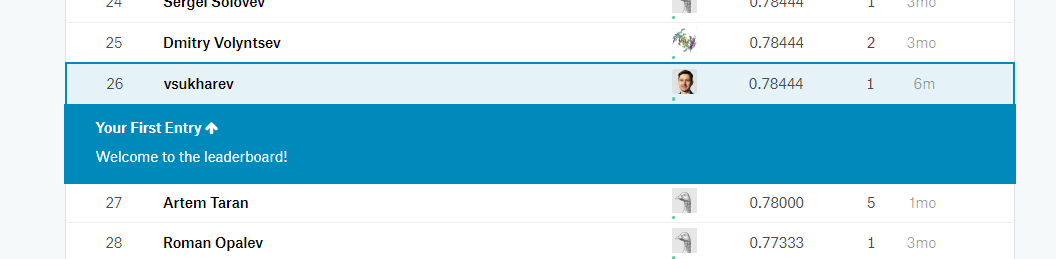

In [28]:
from IPython.display import Image
Image(filename='leaderboard.png')

## Week 3 Kaggle

In [1]:
import numpy as np
import pandas as pd
import cv2

import sys
import warnings

from matplotlib import pyplot as plt

from scipy import stats

if not sys.warnoptions:
    warnings.simplefilter("ignore")
    
import re
from string import digits

### Чтение данных из файла

In [2]:
table = pd.read_csv('products_sentiment_train.tsv', sep='\t', header = None)
table.head()

0  1
0          2 . take around 10,000 640x480 pictures .  1
1  i downloaded a trial version of computer assoc...  1
2  the wrt54g plus the hga7t is a perfect solutio...  1
3  i dont especially like how music files are uns...  0
4  i was using the cheapie pail ... and it worked...  1

### Выделим отдельно текстовые сообщения и метки классов

In [3]:
texts = table.iloc[:,0]
lables = table.iloc[:,1]

### Сделаем предобработку текстовых сообщейни, удалив из них цифры, спец. символы и пробелы

In [4]:
for i in range(len(texts)):
    string = texts[i]
    remove_digits = str.maketrans('', '', digits)
    string = string.translate(remove_digits)
    string = re.sub('\W+',' ', string)
    string = ' '.join( [w for w in string.split() if len(w)>1] )
    string = string.strip()
    texts[i] = string

### Посмотрим на результат

In [5]:
texts[0:5]

0                                 take around pictures
1    downloaded trial version of computer associate...
2    the wrtg plus the hgat is perfect solution if ...
3    dont especially like how music files are unstr...
4    was using the cheapie pail and it worked ok un...
Name: 0, dtype: object

### Начнем рассматривать разные классификаторы оценивать их результаты классификации

In [6]:
from sklearn.feature_extraction.text import TfidfTransformer, CountVectorizer, TfidfVectorizer
from sklearn.linear_model import LogisticRegression, SGDClassifier, LogisticRegressionCV
from sklearn.svm import LinearSVC
from sklearn.model_selection import cross_val_score
from sklearn.pipeline import Pipeline

In [7]:
def text_classifier1 (vectorizer, classifier):
    return Pipeline(
            [("vectorizer", CountVectorizer()),
            ("classifier", LogisticRegression())]
        )

In [8]:
def text_classifier2 (vectorizer, classifier):
    return Pipeline(
            [("vectorizer", CountVectorizer()),
            ("classifier", SGDClassifier())]
        )

In [9]:
def text_classifier3 (vectorizer, classifier):
    return Pipeline(
            [("vectorizer", CountVectorizer()),
            ("classifier", LinearSVC())]
        )

In [10]:
cross_val_score(text_classifier1(CountVectorizer(), LogisticRegression()), texts, lables).mean()

0.7730106418262341

In [11]:
cross_val_score(text_classifier2(CountVectorizer(), SGDClassifier()), texts, lables).mean()

0.7340023681852768

In [12]:
cross_val_score(text_classifier3(CountVectorizer(), LinearSVC()), texts, lables).mean()

0.7475113794454123

## Проведем те же проверки, но с cv = 10

In [13]:
cross_val_score(text_classifier1(CountVectorizer(), LogisticRegression()), texts, lables, cv = 10).mean()

0.7749755493887348

In [14]:
cross_val_score(text_classifier2(CountVectorizer(), SGDClassifier()), texts, lables, cv = 10).mean()

0.750037613440336

In [15]:
cross_val_score(text_classifier3(CountVectorizer(), LinearSVC()), texts, lables, cv = 10).mean()

0.7514450736268407

## Остановим на LogisticRegression. Теперь потестируем разные n-граммы.

In [16]:
def text_classifier2 (vectorizer, classifier):
    return Pipeline(
            [("vectorizer", CountVectorizer(ngram_range=(1,2))),
            ("classifier", LogisticRegression())]
        )

def text_classifier3 (vectorizer, classifier):
    return Pipeline(
            [("vectorizer", CountVectorizer(ngram_range=(3,5))),
            ("classifier", LogisticRegression())]
        )

In [17]:
cross_val_score(text_classifier2(CountVectorizer(ngram_range=(1,2)), LogisticRegression()), texts, lables, cv = 10).mean()

0.7725228880722018

In [18]:
cross_val_score(text_classifier3(CountVectorizer(ngram_range=(3,5)), LogisticRegression()), texts, lables, cv = 10).mean()

0.64300787519688

## Проведем те же проверки, но с разными min_df

In [19]:
def text_classifier4 (vectorizer, classifier):
    return Pipeline(
            [("vectorizer", CountVectorizer(min_df=10)),
            ("classifier", LogisticRegression())]
        )

def text_classifier5 (vectorizer, classifier):
    return Pipeline(
            [("vectorizer", CountVectorizer(min_df=50)),
            ("classifier", LogisticRegression())]
        )

In [20]:
cross_val_score(text_classifier4(CountVectorizer(min_df=10), LogisticRegression()), texts, lables, cv = 10).mean()

0.7489950748768719

In [21]:
cross_val_score(text_classifier5(CountVectorizer(min_df=50), LogisticRegression()), texts, lables, cv = 10).mean()

0.7229969124228106

## Добавим стоп-слова

In [22]:
def text_classifier6 (vectorizer, classifier):
    return Pipeline(
            [("vectorizer", CountVectorizer(stop_words = stop_words)),
            ("classifier", LogisticRegression())]
        )

In [23]:
from sklearn.feature_extraction import stop_words
cross_val_score(text_classifier5(CountVectorizer(stop_words = stop_words), LogisticRegression()), texts, lables, cv = 10).mean()

0.7229969124228106

## Строим модель и делаем предсказание 

In [24]:
table = pd.read_csv('products_sentiment_test.tsv', sep='\t')
ids = table.iloc[:,0]
test_texts = table.iloc[:,1]

In [25]:
for i in range(len(test_texts)):
    string = test_texts[i]
    remove_digits = str.maketrans('', '', digits)
    string = string.translate(remove_digits)
    string = re.sub('\W+',' ', string)
    string = ' '.join( [w for w in string.split() if len(w)>1] )
    string = string.strip()
    test_texts[i] = string

In [26]:
v = CountVectorizer()
mx = v.fit_transform(texts)
test_mx = v.transform(test_texts)
clf = LogisticRegressionCV(cv = 10).fit(mx, lables)

In [27]:
lr_prediction = clf.predict(test_mx)

lr_results = np.array(list(zip(ids,lr_prediction)))
lr_results = pd.DataFrame(lr_results, columns=['id', 'y'])
lr_results.to_csv('lr_vectorized - 1.csv', index = False)